<a href="https://colab.research.google.com/github/San-lab-ship/Prediccion-de-Accidentes-de-Transito/blob/main/Predicci%C3%B3n_de_Accidentes_de_Tr%C3%A1nsito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Muestra de datos:


,latitude,longitude,hour,weather,density,collision_type,severity,high_risk
0,40.431701,-3.716513,8,Clear,33.634569,Choque frontal,Leve,0
1,40.412652,-3.717402,5,Clear,19.817152,Colisión lateral,Leve,0
2,40.436231,-3.757669,3,Clear,72.071389,Salida de vía,Leve,0
3,40.462491,-3.713703,4,Rain,8.747443,Choque frontal,Leve,0
4,40.409775,-3.681815,15,Rain,14.046861,Colisión lateral,Leve,0


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:44:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- RandomForest ---
Precision: 0.385
Recall:    0.269
F1-score:  0.316
AUC-ROC:   0.668
              precision    recall  f1-score   support

           0      0.807     0.876     0.840       971
           1      0.385     0.269     0.316       279

    accuracy                          0.741      1250
   macro avg      0.596     0.573     0.578      1250
weighted avg      0.712     0.741     0.723      1250

--- XGBoost ---
Precision: 0.388
Recall:    0.229
F1-score:  0.288
AUC-ROC:   0.683
              precision    recall  f1-score   support

           0      0.802     0.896     0.846       971
           1      0.388     0.229     0.288       279

    accuracy                          0.747      1250
   macro avg      0.595     0.563     0.567      1250
weighted avg      0.709     0.747     0.722      1250



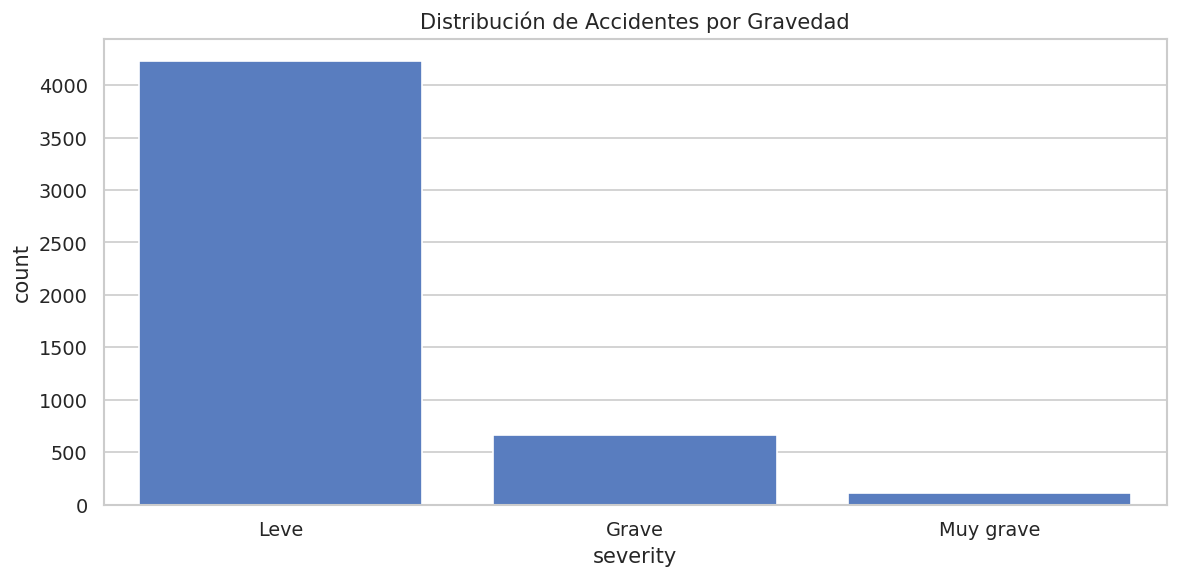

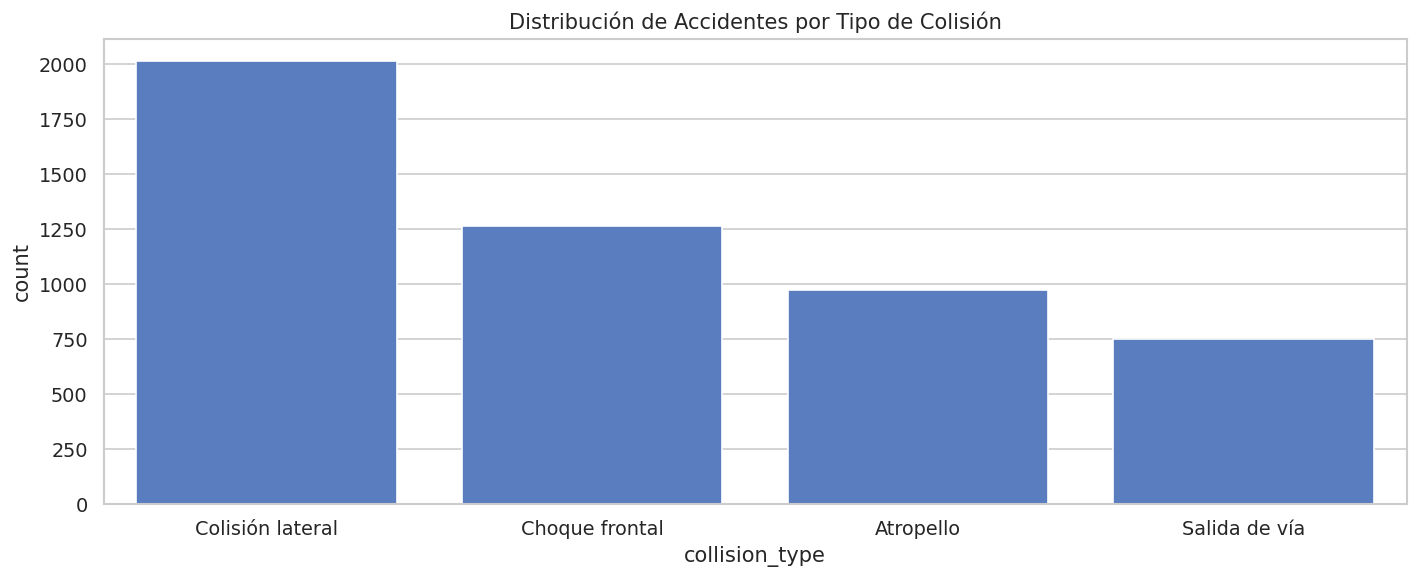

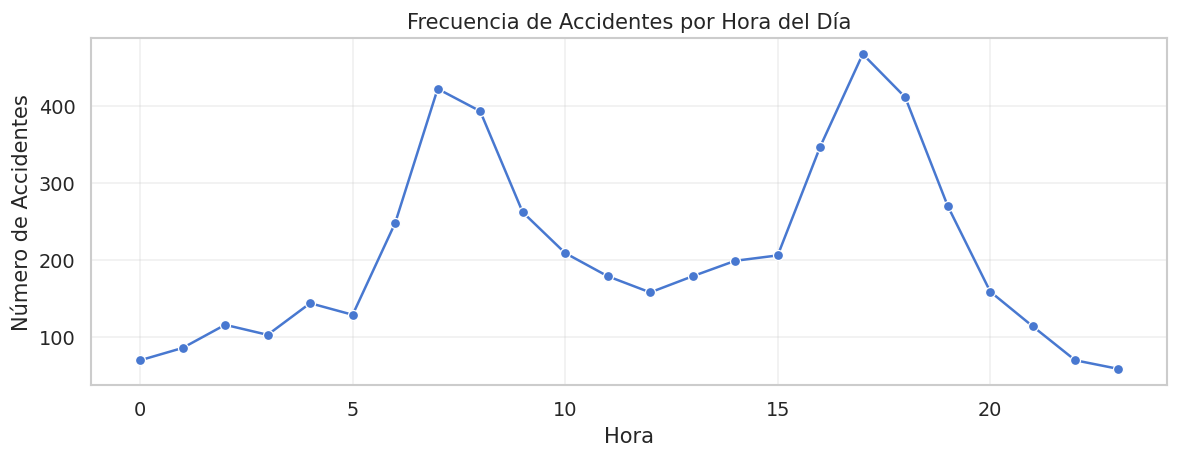

/tmp/ipython-input-2638348763.py:169: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=df['longitude'], y=df['latitude'], cmap="Reds", shade=True, bw_method=0.08, thresh=0.03)


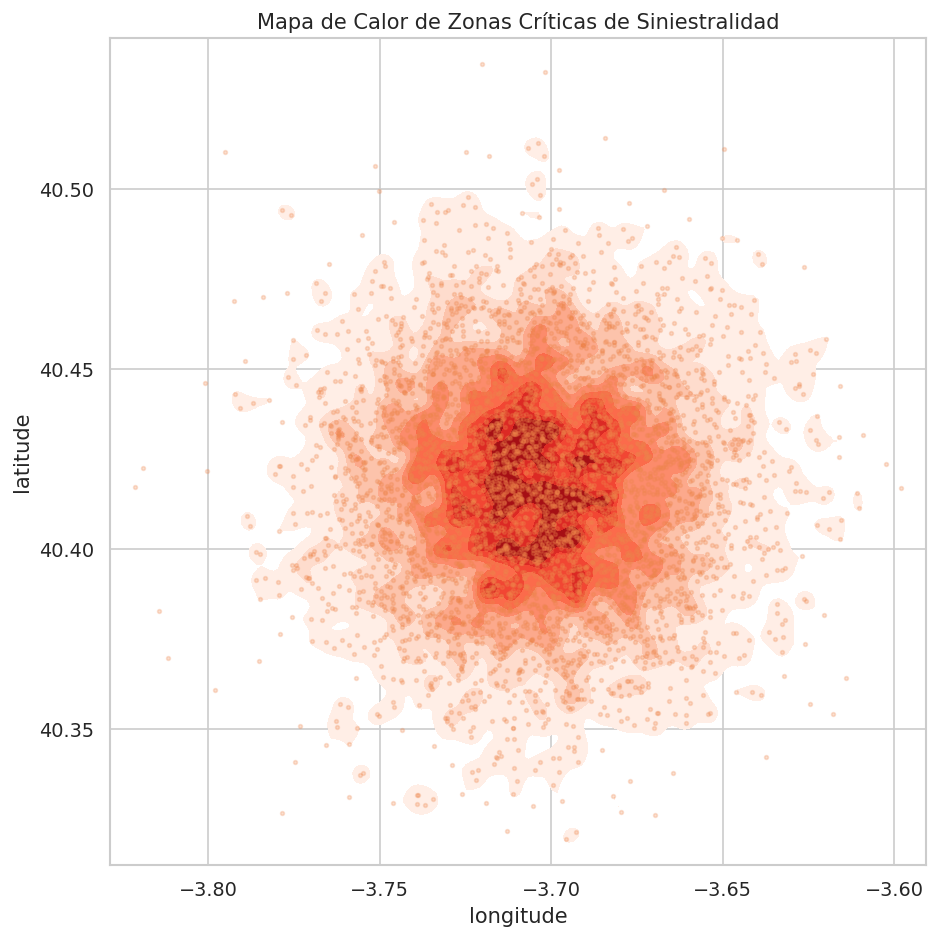

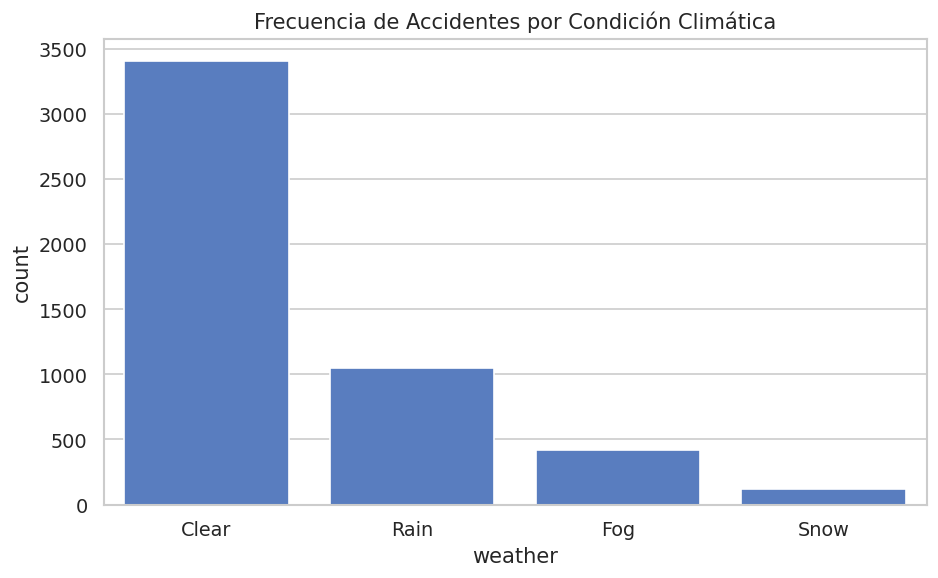

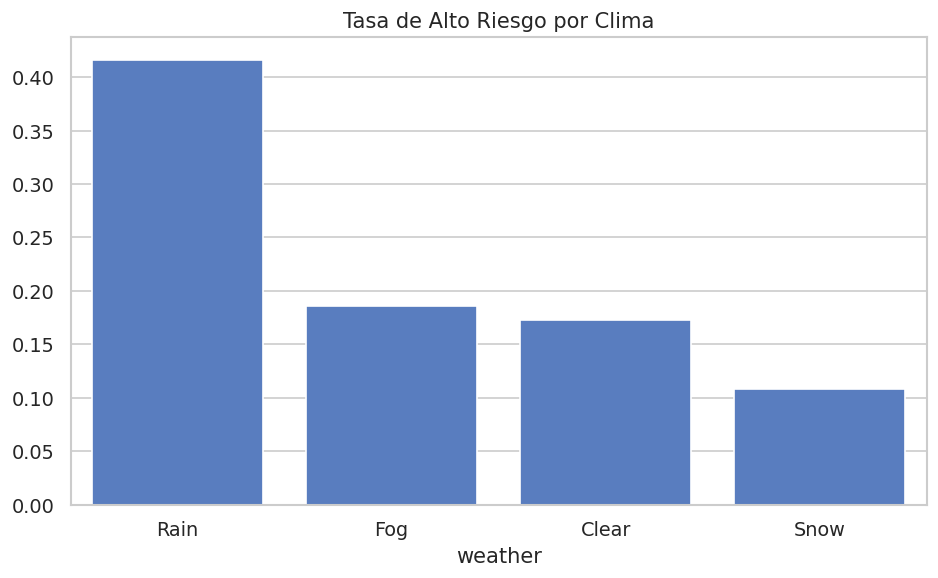

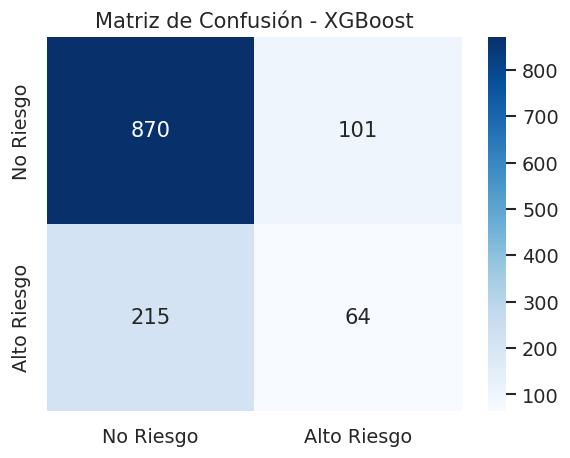

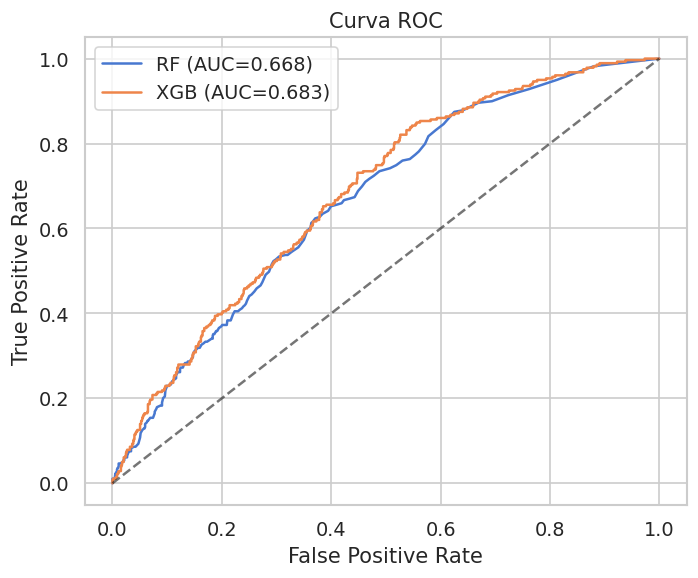

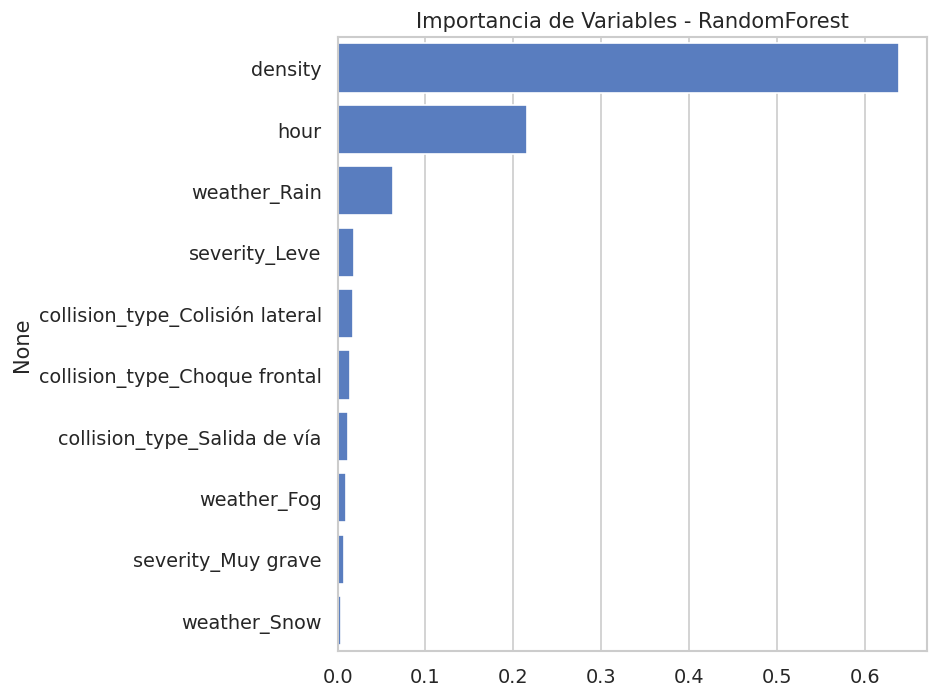

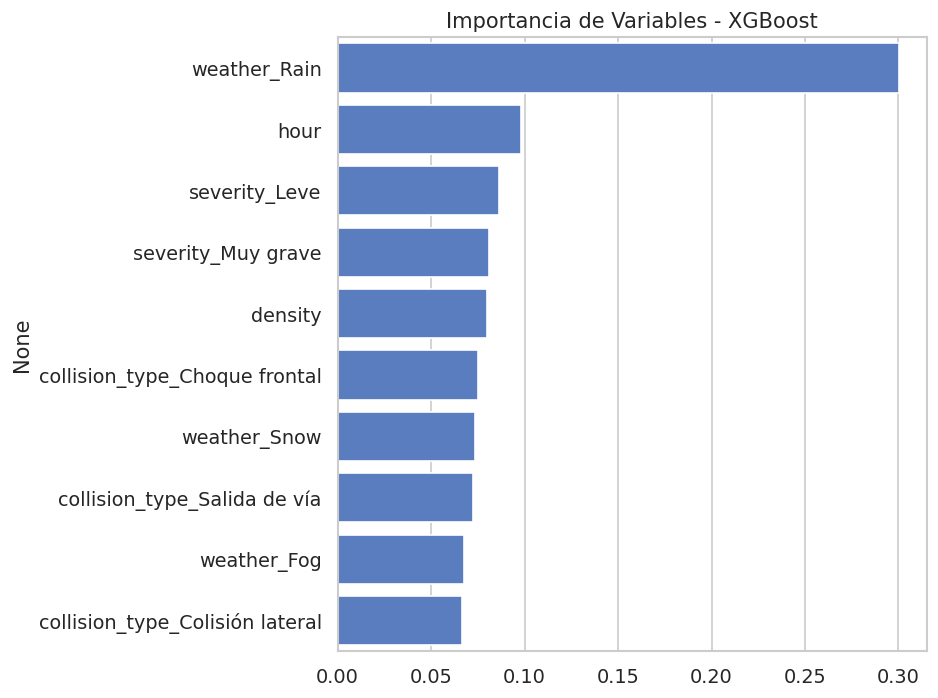

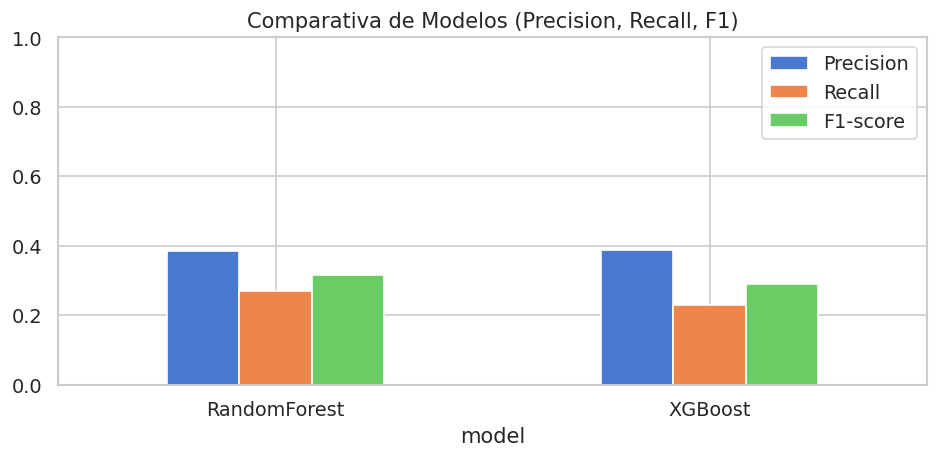

✅ Figuras guardadas en la carpeta 'figuras'
✅ Mapa interactivo mostrado arriba (Folium)


In [2]:
# ===========================
# Predicción de Accidentes - Métricas y Visualizaciones
# ===========================

!pip install xgboost folium --quiet

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix,
                             classification_report)
from sklearn.preprocessing import StandardScaler
import os

sns.set(style="whitegrid", palette="muted", font_scale=1.05)
plt.rcParams['figure.dpi'] = 120

# Crear carpeta para guardar imágenes
os.makedirs("figuras", exist_ok=True)

# ======================================================
# SIMULACIÓN DE DATOS (Reemplaza con tu CSV si tienes)
# ======================================================
np.random.seed(42)
n = 5000

# Coordenadas (ciudad ficticia)
lat_center, lon_center = 40.4168, -3.7038  # Madrid centro como referencia
lats = lat_center + np.random.normal(scale=0.03, size=n)
lons = lon_center + np.random.normal(scale=0.03, size=n)

# --- Corrección: horas del día con probabilidades que suman 1 ---
p_hours = np.array([
    0.015, 0.015, 0.02, 0.02, 0.025, 0.03,   # madrugada
    0.05, 0.08, 0.08, 0.05, 0.04, 0.035,     # mañana
    0.03, 0.03, 0.035, 0.04, 0.07, 0.09,     # tarde
    0.08, 0.05, 0.03, 0.02, 0.015, 0.01      # noche
])
p_hours = p_hours / p_hours.sum()
hours = np.random.choice(range(0,24), size=n, p=p_hours)

# Clima
weathers = np.random.choice(['Clear','Rain','Fog','Snow'], size=n, p=[0.7,0.2,0.08,0.02])

# Densidad vehicular (vehículos/hora)
density = np.random.gamma(shape=2.0, scale=30.0, size=n)

# Tipo y gravedad del accidente
collision_type = np.random.choice(['Colisión lateral','Choque frontal','Atropello','Salida de vía'],
                                  size=n, p=[0.4,0.25,0.2,0.15])
severity = np.random.choice(['Leve','Grave','Muy grave'], size=n, p=[0.85,0.13,0.02])

# Probabilidad base de "alto riesgo"
prob = (
    0.02 +
    0.15*((hours>=6)&(hours<=9)) +
    0.18*((hours>=17)&(hours<=20)) +
    0.25*(weathers=='Rain') +
    0.2*(density>np.percentile(density,75)) +
    0.18*((np.abs(lats-lat_center)<0.01)&(np.abs(lons-lon_center)<0.01))
)
prob = np.clip(prob,0,0.95)
labels = np.random.binomial(1, prob)

df = pd.DataFrame({
    'latitude': lats,
    'longitude': lons,
    'hour': hours,
    'weather': weathers,
    'density': density,
    'collision_type': collision_type,
    'severity': severity,
    'high_risk': labels
})

print("Muestra de datos:")
display(df.head())

# ======================================================
# FEATURES / PREPROCESSING
# ======================================================
df_enc = pd.get_dummies(df, columns=['weather','collision_type','severity'], drop_first=True)
X = df_enc.drop(columns=['high_risk','latitude','longitude'])
y = df_enc['high_risk'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

# ======================================================
# ENTRENAMIENTO
# ======================================================
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
xgb = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42)

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:,1]

# ======================================================
# MÉTRICAS
# ======================================================
def metrics_report(y_true, y_pred, y_prob, model_name):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    print(f"--- {model_name} ---")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1-score:  {f1:.3f}")
    print(f"AUC-ROC:   {auc:.3f}")
    print(classification_report(y_true, y_pred, digits=3))
    return {'model': model_name, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}

rep_rf = metrics_report(y_test, y_pred_rf, y_prob_rf, "RandomForest")
rep_xgb = metrics_report(y_test, y_pred_xgb, y_prob_xgb, "XGBoost")

# ======================================================
# VISUALIZACIONES
# ======================================================

# 1️⃣ Distribución de Accidentes por Gravedad
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='severity', order=['Leve','Grave','Muy grave'])
plt.title("Distribución de Accidentes por Gravedad")
plt.tight_layout()
plt.savefig("figuras/distribucion_gravedad.png")
plt.show()

# 2️⃣ Por Tipo de Colisión
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='collision_type', order=df['collision_type'].value_counts().index)
plt.title("Distribución de Accidentes por Tipo de Colisión")
plt.tight_layout()
plt.savefig("figuras/distribucion_tipo.png")
plt.show()

# 3️⃣ Frecuencia por Hora
hour_counts = df.groupby('hour').size().reindex(range(24), fill_value=0)
plt.figure(figsize=(10,4))
sns.lineplot(x=hour_counts.index, y=hour_counts.values, marker='o')
plt.title("Frecuencia de Accidentes por Hora del Día")
plt.xlabel("Hora")
plt.ylabel("Número de Accidentes")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figuras/frecuencia_por_hora.png")
plt.show()

# 4️⃣ Mapa de Calor de Zonas Críticas
plt.figure(figsize=(8,8))
sns.kdeplot(x=df['longitude'], y=df['latitude'], cmap="Reds", shade=True, bw_method=0.08, thresh=0.03)
plt.scatter(df['longitude'], df['latitude'], s=5, alpha=0.25)
plt.title("Mapa de Calor de Zonas Críticas de Siniestralidad")
plt.tight_layout()
plt.savefig("figuras/mapa_calor_kde.png")
plt.show()

# 5️⃣ Impacto del Clima
plt.figure(figsize=(8,5))
sns.countplot(x='weather', data=df)
plt.title("Frecuencia de Accidentes por Condición Climática")
plt.tight_layout()
plt.savefig("figuras/frecuencia_clima.png")
plt.show()

risk_by_weather = df.groupby('weather')['high_risk'].mean().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=risk_by_weather.index, y=risk_by_weather.values)
plt.title("Tasa de Alto Riesgo por Clima")
plt.tight_layout()
plt.savefig("figuras/tasa_riesgo_clima.png")
plt.show()

# 6️⃣ Matriz de Confusión (XGBoost)
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Riesgo','Alto Riesgo'],
            yticklabels=['No Riesgo','Alto Riesgo'])
plt.title("Matriz de Confusión - XGBoost")
plt.tight_layout()
plt.savefig("figuras/matriz_confusion.png")
plt.show()

# 7️⃣ Curva ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
plt.figure(figsize=(6,5))
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC={rep_rf["auc"]:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC={rep_xgb["auc"]:.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.tight_layout()
plt.savefig("figuras/roc.png")
plt.show()

# 8️⃣ Importancia de Variables
feature_names = X.columns
imp_rf = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False).head(15)
imp_xgb = pd.Series(xgb.feature_importances_, index=feature_names).sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=imp_rf.values, y=imp_rf.index)
plt.title("Importancia de Variables - RandomForest")
plt.tight_layout()
plt.savefig("figuras/importancia_rf.png")
plt.show()

plt.figure(figsize=(8,6))
sns.barplot(x=imp_xgb.values, y=imp_xgb.index)
plt.title("Importancia de Variables - XGBoost")
plt.tight_layout()
plt.savefig("figuras/importancia_xgb.png")
plt.show()

# 9️⃣ Comparativa de Modelos
metrics_df = pd.DataFrame([rep_rf, rep_xgb]).set_index('model')[['precision','recall','f1','auc']]
metrics_df = metrics_df.rename(columns={'precision':'Precision','recall':'Recall','f1':'F1-score','auc':'AUC-ROC'})

metrics_df[['Precision','Recall','F1-score']].plot(kind='bar', rot=0, figsize=(8,4))
plt.title("Comparativa de Modelos (Precision, Recall, F1)")
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("figuras/comparativa_modelos.png")
plt.show()

# 🔟 Mapa Interactivo (Folium)
heat_data = df.loc[df['high_risk']==1, ['latitude','longitude']].values.tolist()
m = folium.Map(location=[lat_center, lon_center], zoom_start=12)
HeatMap(heat_data, radius=10, blur=15, max_zoom=13).add_to(m)
m

print("✅ Figuras guardadas en la carpeta 'figuras'")
print("✅ Mapa interactivo mostrado arriba (Folium)")
